Workflow demonstration
===

These notebooks serve as a tutorial for the workflow building related to the NSBI analysis recently published by ATLAS:

- An implementation of neural simulation-based inference for parameter estimation in ATLAS (https://arxiv.org/pdf/2412.01600)
- Measurement of off-shell Higgs boson production in the $H\to ZZ \to 4\ell$ decay channel using a neural simulation-based inference technique in 13 TeV p-p collisions with the ATLAS detector (https://arxiv.org/pdf/2412.01548)

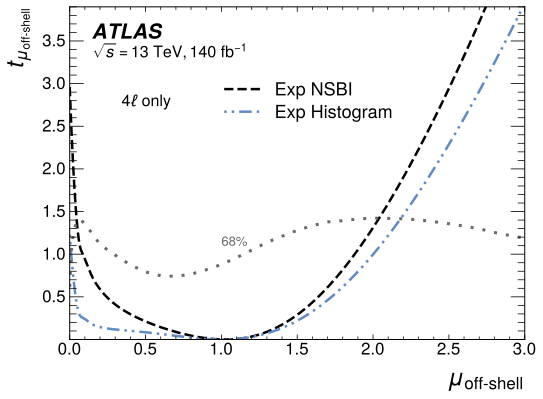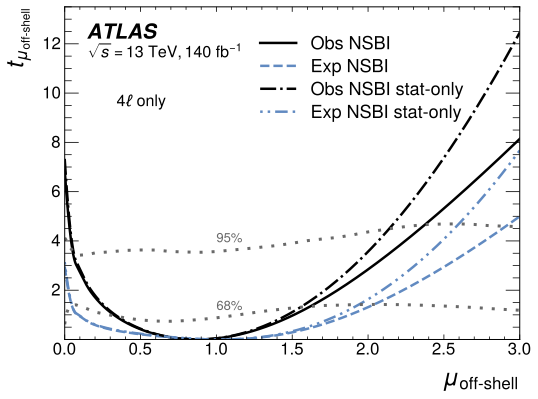


Several novel developments have been done to make the full off-shell Higgs boson analysis possible, some of which will be covered in this tutorial.

**Note: The tutorial is a significantly scaled down and incomplete version of the original workflow. More complete versions will follow!**


In [1]:
import logging
import time

import utils 

import awkward as ak
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import mplhep as hep
hep.style.use(hep.style.ATLAS)

In [2]:
N_FILES_MAX_PER_SAMPLE = 1
USE_DASK=False
USE_SERVICEX=False
USE_SAVED_FEATURES=False

In [3]:
fileset = utils.file_input.construct_fileset(
    N_FILES_MAX_PER_SAMPLE,
    use_xcache=False,
    af_name="coffea_casa",  
    input_from_eos=False,
    xcache_atlas_prefix=None,
)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__scaleup']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'scaleup', 'nevts': 1278695, 'xsec': 729.84}
}


In [4]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

executor = processor.FuturesExecutor(workers=4)

run = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    savemetrics=True,
    metadata_cache={},
    chunksize=200000)

treename = "Events"


filemeta = run.preprocess(fileset, treename=treename)  # pre-processing



Output()

In [10]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

Working with CMS ttbar open data
===
Neural Simulation-Based Inference, as the name suggests relies heavily on the robust simulation modelling of probability distributions. To train NNs that act as unbiased and low-variance proxies of these very complex probability distributions requires also that they see enough simulated training events. 

With the CMS open ttbar data, the signal process is easily distinguishable from background and hence the **preselections chosen here have been made as loose as possible to retain maximum background simulation statistics**. 

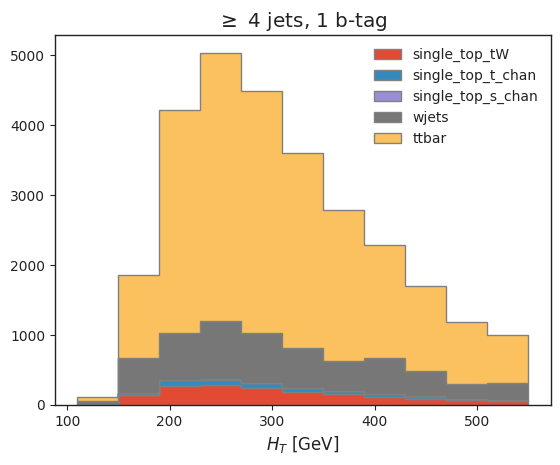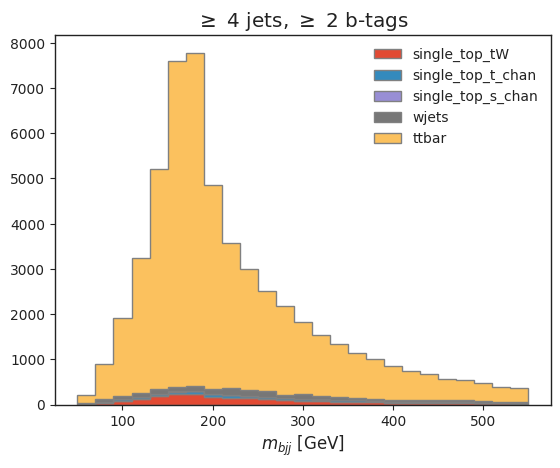

No b-tagging requirements are made, nor are a minimum number of jets in the final state enforced. **This is only a toy version of the original analysis to illustrate the NSBI workflow.** 

Since adding jet-related features like b-tagging can also isolate phase spaces with low background statistics, only the single lepton kinematics are used as multi-dimensional training features for the modelling of likelihood ratio. 

In [24]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class NSBI_analysis(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        # Note: This creates new objects, distinct from those in the 'events' object
        elecs = events.Electron
        muons = events.Muon
        jets = events.Jet
        
        process = events.metadata["process"]  # "ttbar" etc.
        
        if process in ["single_top_s_chan", "single_top_tW"]: 
            return {}
        
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb

        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        electron_reqs = (elecs.pt > 10) & (np.abs(elecs.eta) < 2.4) & (elecs.pt < 500)
        muon_reqs = ((muons.pt > 10) & (np.abs(muons.eta) < 2.4)) & (muons.pt < 500)
        jet_reqs = (jets.pt > 5) & (np.abs(jets.eta) < 2.4) #& (jets.isTightLeptonVeto)

        # Only keep objects that pass our requirements
        elecs = elecs[electron_reqs]
        muons = muons[muon_reqs]
        jets = jets[jet_reqs]

        ######### Store boolean masks with PackedSelection ##########
        selections = PackedSelection(dtype='uint64')
        
        # Inclusive selection criteria 
        selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
        selections.add("min_HT", ak.sum(jets.pt, axis=-1) >= 5) 
        selections.add("max_HT", ak.sum(jets.pt, axis=-1) <= 1750) # Selections to ensure good statistics throughout phase space
        # selections.add("atleast_4j", ak.num(jets) >= 4)
        
        selections.add("Inclusive", selections.all("exactly_1l", "min_HT", "max_HT"))
        # selections.add("Inclusive", selections.all("exactly_1l", "atleast_4j")) # the 4j selection cuts away a large part of the wjets background, leaving meager stats

        selection = selections.all("Inclusive")
        selected_jets = jets[selection]
        selected_elecs = elecs[selection]
        selected_muons = muons[selection]
        selected_weights = np.ones(len(selected_jets)) * xsec_weight


        # grab lepton info
        leptons = ak.flatten(ak.concatenate((selected_elecs, selected_muons), axis=1), axis=-1)

        H_T = ak.sum(selected_jets.pt, axis=-1)
        pT_lep = leptons.pt
        eta_lep = leptons.eta
        phi_lep = leptons.phi
        n_jets = ak.num(selected_jets)
        
        #### calculate features ####
        features = np.zeros((len(pT_lep), 4))
        
        features[:, 0] = pT_lep
        features[:, 1] = eta_lep
        features[:, 2] = phi_lep
        features[:, 3] = H_T
        # features[:, 4] = selected_jets.btagCSVV2[:,0]
        # features[:, 5] = selected_jets.btagCSVV2[:,1]
        # features[:, 6] = selected_jets.btagCSVV2[:,2]
        # features[:, 7] = selected_jets.btagCSVV2[:,3]


        train_labels = np.full_like(pT_lep, labels_dict[process])


        output = {"train_labels": col_accumulator(train_labels.tolist()),
                  "weights": col_accumulator(selected_weights.tolist()),
                  "features": col_accumulator(features.tolist())}


        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [25]:
if not USE_SAVED_FEATURES:
    
    t0 = time.monotonic()
    # processing
    output, metrics = run(
        fileset,
        treename,
        processor_instance=NSBI_analysis()
    )


    exec_time = time.monotonic() - t0


    print(f"\nexecution took {exec_time:.2f} seconds")

Output()


execution took 99.58 seconds


In [26]:
saved_data = "./cached_data/"

In [48]:
if USE_SAVED_FEATURES:
    
    features = np.load(f"{saved_data}features.npy")
    train_labels = np.load(f"{saved_data}train_labels.npy")
    weights = np.load(f"{saved_data}weights.npy")
    
else:

    # grab features and labels and convert to np array
    features = np.array(output['features'].value)
    train_labels = np.array(output['train_labels'].value, dtype='int')
    weights = np.array(output['weights'].value)
    
    np.save(f"{saved_data}features.npy", features)
    np.save(f"{saved_data}train_labels.npy", train_labels)        
    np.save(f"{saved_data}weights.npy", weights)        

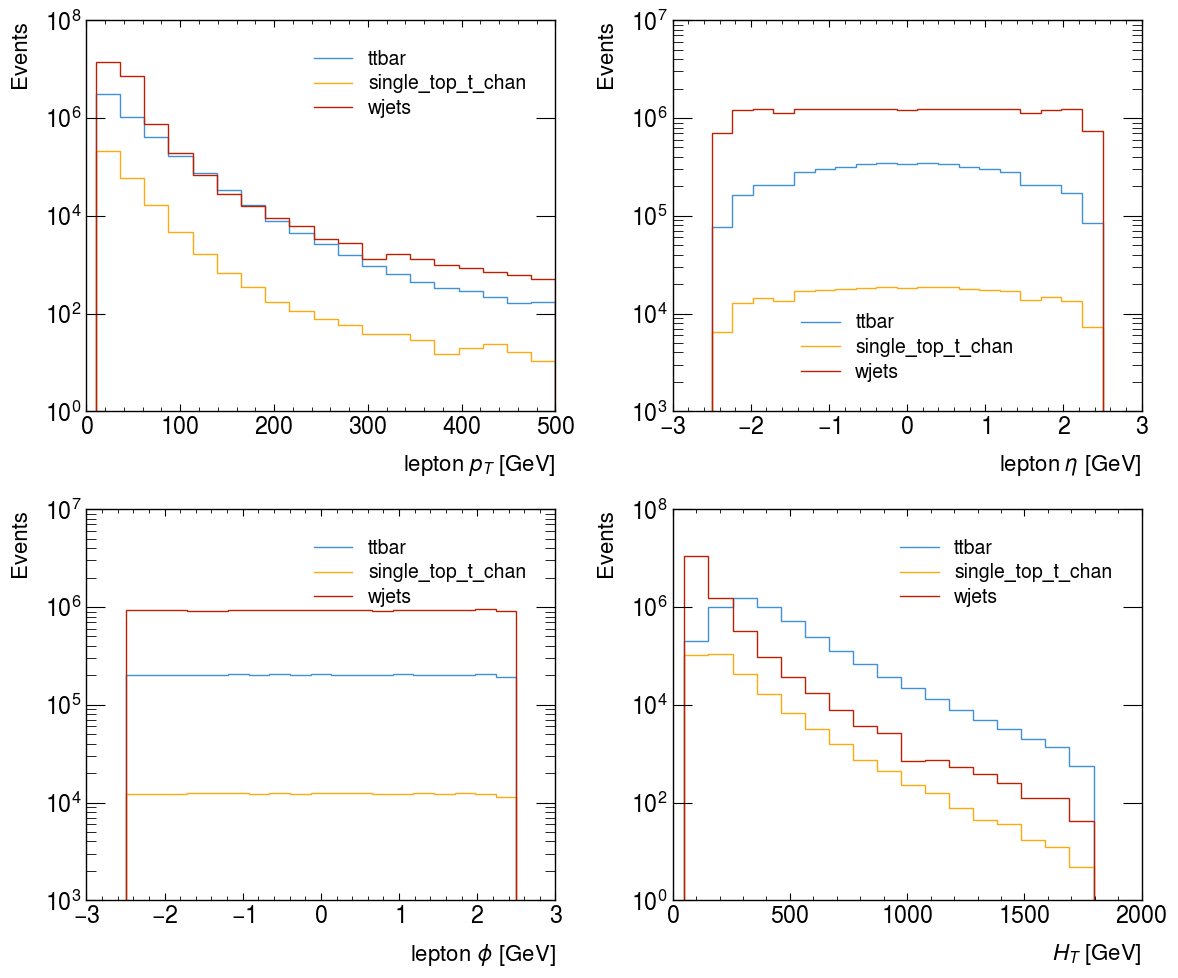

In [47]:
# Plot the training features to be used

bins_dict = {
    'lep_pt': np.linspace(10.0, 500.0, num=20),
    'lep_eta': np.linspace(-2.5, 2.5, num=20),
    'lep_phi': np.linspace(-2.5, 2.5, num=20),
    'H_T': np.linspace(50.0, 2000.0, num=20)
}

data_dict = {
    'lep_pt': 0,  # Column index for lep_pt
    'lep_eta': 1, # Column index for lep_eta
    'lep_phi': 2, # Column index for lep_phi
    'H_T': 3       # Column index for H_T
}

xlabel_dict = {
    'lep_pt': 'lepton $p_T$ [GeV]', 
    'lep_eta': 'lepton $\eta$ [GeV]', 
    'lep_phi': 'lepton $\phi$ [GeV]', 
    'H_T': '$H_T$ [GeV]'      
}

histograms = {}
for key, bin_edges in bins_dict.items():
    histograms[key] = {}
    for label in labels_dict:
        histograms[key][label], _ = np.histogram(
            features[:, data_dict[key]][train_labels == labels_dict[label]], 
            weights=weights[train_labels == labels_dict[label]], 
            bins=bin_edges
        )

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plot_labels = ['lep_pt', 'lep_eta', 'lep_phi', 'H_T']

for i, key in enumerate(plot_labels):
    for label in labels_dict:
        hep.histplot(histograms[key][label], bins=bins_dict[key], label=label, ax=axes[i])
    
    axes[i].set_yscale('log')
    axes[i].set_xlabel(xlabel_dict[key], size=16)
    axes[i].set_ylabel('Events', size=16)
    axes[i].legend()

plt.tight_layout()
plt.show()


After processing and saving all the data, we move to the second notebook - `Neural_Likelihood_Ratio_training.ipynb`